## V9+sub1+Optuna_LightGBM_kfold5

In [1]:
import os, sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# path 설정
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath("")))))
print(sys.path[-1])

d:\base\boostcamp\apart\level2-competitiveds-recsys-06


In [2]:
raw_path: str = "../../../data/raw"
processed_path: str = "../../../data/processed"
submission_path: str = "../../../data/submission"

In [3]:
v9: pd.DataFrame = pd.read_csv(os.path.join(processed_path,"v9.csv"))

In [4]:
v9.columns

Index(['index', '_type', 'contract_year_month', 'contract_day', 'area_m2',
       'contract_date_numeric', 'floor', 'built_year', 'latitude', 'longitude',
       'age', 'contract_0', 'contract_1', 'deposit', 'apt_idx', 'area',
       'grid_deposit', 'apt_deposit_rank', 'apt_area_deposit_rank',
       'recent_deposit', 'interest_rate', 'grid_id', 'nearest_park_distance',
       'nearest_park_idx', 'park_grid_id', 'park_area',
       'nearest_school_distance', 'nearest_school_idx', 'school_grid_id',
       'nearest_subway_distance', 'nearest_subway_idx', 'subway_grid_id',
       'park_count', 'school_count', 'subway_count', 'date_length',
       'contract_date', 'contract_timestamp'],
      dtype='object')

In [5]:
v8: pd.DataFrame = pd.read_csv(os.path.join(processed_path,"V8+subway_1.csv"))
# v8의 subway_1 컬럼을 v9에 추가
v9_sub1 = v9.merge(v8[['index', '_type', 'subway_1']], on=['index', '_type'], how='left')

# 결과 확인
v9_sub1.head()

,index,_type,contract_year_month,contract_day,area_m2,contract_date_numeric,floor,built_year,latitude,longitude,...,nearest_subway_distance,nearest_subway_idx,subway_grid_id,park_count,school_count,subway_count,date_length,contract_date,contract_timestamp,subway_1
0,0,train,201906,25,84.9981,20190625,9,2019,37.054314,127.045216,...,716.952948,12,521.0,9.0,15,1,8,2019-06-25,1561388400,0
1,1,train,202003,26,84.9981,20200326,20,2019,37.054314,127.045216,...,716.952948,12,521.0,9.0,15,1,8,2020-03-26,1585148400,0
2,2,train,202003,28,84.9981,20200328,8,2019,37.054314,127.045216,...,716.952948,12,521.0,9.0,15,1,8,2020-03-28,1585321200,0
3,3,train,201907,15,59.3400,20190715,1,1986,36.964647,127.055847,...,3897.279708,10,222.0,7.0,3,1,8,2019-07-15,1563116400,0
4,4,train,201904,12,59.8100,20190412,6,1995,36.972390,127.084514,...,2039.685349,10,222.0,1.0,6,1,8,2019-04-12,1554994800,0


### 컬럼 정리

In [6]:
columns = ['index','_type',
    'contract_date_numeric', 
    'area_m2',
    'floor', 'built_year', 'latitude', 'longitude','age', 
    'contract_0', 'contract_1', 
    'deposit', 
    'apt_idx', 
    'area',
    'grid_deposit', 
    'apt_deposit_rank', 'apt_area_deposit_rank',
    'recent_deposit', 
    'nearest_park_distance','nearest_park_idx', 'park_area',
    'nearest_school_distance', 'nearest_school_idx',
    'nearest_subway_distance', 'nearest_subway_idx',
    'park_count', 'school_count', 'subway_count','subway_1']
df = v9_sub1.filter(items=columns)


temp_train_df = df[df["_type"]=='train']
test_df = df[df["_type"]=='test']

In [7]:
df.isna().sum()

index                           0
_type                           0
contract_date_numeric           0
area_m2                         0
floor                           0
built_year                      0
latitude                        0
longitude                       0
age                             0
contract_0                      0
contract_1                      0
deposit                    150172
apt_idx                         0
area                            0
grid_deposit                    0
apt_deposit_rank                0
apt_area_deposit_rank           0
recent_deposit              67857
nearest_park_distance           0
nearest_park_idx                0
park_area                       0
nearest_school_distance         0
nearest_school_idx              0
nearest_subway_distance         0
nearest_subway_idx              0
park_count                     88
school_count                    0
subway_count                    0
subway_1                        0
dtype: int64

## K-Fold CV(k=5) 적용 LightGBM

In [16]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import optuna

# 학습에 사용할 특징 열
feature_columns = [col for col in temp_train_df.columns if col not in ['deposit', '_type', 'index']]

# 학습 데이터 준비
X = temp_train_df[feature_columns]
y = temp_train_df['deposit']


# 5-fold 교차 검증 설정
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

def objective(trial):
    # 하이퍼파라미터 탐색 공간 정의
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 21, 51),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.05),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.8, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.8, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'seed': 42,
    }
    
    # 교차 검증 결과를 저장할 변수
    cv_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        dtrain = lgb.Dataset(X_train, label=y_train)
        dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)
        
        model = lgb.train(
            params,
            dtrain,
            num_boost_round=500,
            valid_sets=[dval],
        )
        
        val_pred = model.predict(X_val)
        fold_mae = mean_absolute_error(y_val, val_pred)
        cv_scores.append(fold_mae)
    
    return np.mean(cv_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best parameters:", study.best_params)
print("Best MAE:", study.best_value)

[I 2024-10-23 14:21:48,699] A new study created in memory with name: no-name-a35a66e9-8593-4ed0-ae0a-c6093c1a31c1


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 14:23:49,970] Trial 0 finished with value: 3870.7884784245252 and parameters: {'num_leaves': 34, 'learning_rate': 0.05, 'feature_fraction': 0.8185295407172182, 'bagging_fraction': 0.8090748387602129, 'bagging_freq': 6, 'min_child_samples': 81, 'max_depth': 19}. Best is trial 0 with value: 3870.7884784245252.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 14:26:15,774] Trial 1 finished with value: 3858.223585950075 and parameters: {'num_leaves': 36, 'learning_rate': 0.05, 'feature_fraction': 0.8086343838817384, 'bagging_fraction': 0.956822008842811, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 42}. Best is trial 1 with value: 3858.223585950075.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 14:28:19,673] Trial 2 finished with value: 3882.988016735397 and parameters: {'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.9438607925973623, 'bagging_fraction': 0.8661661562673812, 'bagging_freq': 9, 'min_child_samples': 15, 'max_depth': 9}. Best is trial 1 with value: 3858.223585950075.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 14:30:31,489] Trial 3 finished with value: 3880.92443208447 and parameters: {'num_leaves': 27, 'learning_rate': 0.05, 'feature_fraction': 0.9174616292117618, 'bagging_fraction': 0.9891999364341286, 'bagging_freq': 10, 'min_child_samples': 33, 'max_depth': 34}. Best is trial 1 with value: 3858.223585950075.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 14:33:04,339] Trial 4 finished with value: 3832.7085440794435 and parameters: {'num_leaves': 46, 'learning_rate': 0.05, 'feature_fraction': 0.879462666256128, 'bagging_fraction': 0.9140200341904833, 'bagging_freq': 10, 'min_child_samples': 80, 'max_depth': 18}. Best is trial 4 with value: 3832.7085440794435.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 14:35:24,174] Trial 5 finished with value: 3854.563415482652 and parameters: {'num_leaves': 37, 'learning_rate': 0.05, 'feature_fraction': 0.9947414986111238, 'bagging_fraction': 0.9174929735695211, 'bagging_freq': 7, 'min_child_samples': 66, 'max_depth': 16}. Best is trial 4 with value: 3832.7085440794435.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 14:37:50,998] Trial 6 finished with value: 3839.025032762113 and parameters: {'num_leaves': 51, 'learning_rate': 0.05, 'feature_fraction': 0.8270793482235712, 'bagging_fraction': 0.8101161271116484, 'bagging_freq': 4, 'min_child_samples': 53, 'max_depth': 32}. Best is trial 4 with value: 3832.7085440794435.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 14:40:26,762] Trial 7 finished with value: 3834.9059022027673 and parameters: {'num_leaves': 47, 'learning_rate': 0.05, 'feature_fraction': 0.9764169646313305, 'bagging_fraction': 0.9961422092569301, 'bagging_freq': 4, 'min_child_samples': 18, 'max_depth': 48}. Best is trial 4 with value: 3832.7085440794435.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 14:42:26,399] Trial 8 finished with value: 3895.658256557332 and parameters: {'num_leaves': 27, 'learning_rate': 0.05, 'feature_fraction': 0.9531449987792846, 'bagging_fraction': 0.8493997594594147, 'bagging_freq': 8, 'min_child_samples': 19, 'max_depth': 49}. Best is trial 4 with value: 3832.7085440794435.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 14:44:50,541] Trial 9 finished with value: 3855.1369567601105 and parameters: {'num_leaves': 34, 'learning_rate': 0.05, 'feature_fraction': 0.9396045297907608, 'bagging_fraction': 0.9764681069732278, 'bagging_freq': 6, 'min_child_samples': 72, 'max_depth': 47}. Best is trial 4 with value: 3832.7085440794435.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 14:47:28,671] Trial 10 finished with value: 3837.6812782848147 and parameters: {'num_leaves': 43, 'learning_rate': 0.05, 'feature_fraction': 0.8643002872572816, 'bagging_fraction': 0.9190266074183434, 'bagging_freq': 10, 'min_child_samples': 98, 'max_depth': 23}. Best is trial 4 with value: 3832.7085440794435.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-10-23 14:50:20,664] Trial 11 finished with value: 3830.660418865055 and parameters: {'num_leaves': 49, 'learning_rate': 0.05, 'feature_fraction': 0.8746172605677053, 'bagging_fraction': 0.9455615633176836, 'bagging_freq': 3, 'min_child_samples': 50, 'max_depth': 9}. Best is trial 11 with value: 3830.660418865055.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the o

[I 2024-10-23 14:53:14,211] Trial 12 finished with value: 3838.052432160616 and parameters: {'num_leaves': 44, 'learning_rate': 0.05, 'feature_fraction': 0.8766363601004982, 'bagging_fraction': 0.9406998277899187, 'bagging_freq': 3, 'min_child_samples': 50, 'max_depth': 9}. Best is trial 11 with value: 3830.660418865055.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-10-23 14:56:12,134] Trial 13 finished with value: 3864.471769653799 and parameters: {'num_leaves': 51, 'learning_rate': 0.05, 'feature_fraction': 0.8656352779105722, 'bagging_fraction': 0.8844270928919453, 'bagging_freq': 8, 'min_child_samples': 89, 'max_depth': 7}. Best is trial 11 with value: 3830.660418865055.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 14:58:42,886] Trial 14 finished with value: 3842.139159878659 and parameters: {'num_leaves': 42, 'learning_rate': 0.05, 'feature_fraction': 0.8955802602000906, 'bagging_fraction': 0.9444684780552058, 'bagging_freq': 5, 'min_child_samples': 42, 'max_depth': 15}. Best is trial 11 with value: 3830.660418865055.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 15:01:19,782] Trial 15 finished with value: 3834.14746578662 and parameters: {'num_leaves': 48, 'learning_rate': 0.05, 'feature_fraction': 0.8449065962786195, 'bagging_fraction': 0.9035478089825857, 'bagging_freq': 3, 'min_child_samples': 63, 'max_depth': 25}. Best is trial 11 with value: 3830.660418865055.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 15:03:48,727] Trial 16 finished with value: 3840.2635683060885 and parameters: {'num_leaves': 40, 'learning_rate': 0.05, 'feature_fraction': 0.9021553607054804, 'bagging_fraction': 0.965430637957346, 'bagging_freq': 8, 'min_child_samples': 78, 'max_depth': 13}. Best is trial 11 with value: 3830.660418865055.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 15:05:52,277] Trial 17 finished with value: 3904.1442487649533 and parameters: {'num_leaves': 22, 'learning_rate': 0.05, 'feature_fraction': 0.8484738947443258, 'bagging_fraction': 0.92807771478516, 'bagging_freq': 7, 'min_child_samples': 59, 'max_depth': 21}. Best is trial 11 with value: 3830.660418865055.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-10-23 15:08:17,920] Trial 18 finished with value: 3929.6968420167987 and parameters: {'num_leaves': 47, 'learning_rate': 0.05, 'feature_fraction': 0.897763093877803, 'bagging_fraction': 0.8910528192838363, 'bagging_freq': 5, 'min_child_samples': 43, 'max_depth': 5}. Best is trial 11 with value: 3830.660418865055.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 15:10:41,018] Trial 19 finished with value: 3855.262118857177 and parameters: {'num_leaves': 40, 'learning_rate': 0.05, 'feature_fraction': 0.9208319942150304, 'bagging_fraction': 0.8430800676510657, 'bagging_freq': 9, 'min_child_samples': 96, 'max_depth': 32}. Best is trial 11 with value: 3830.660418865055.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 15:13:13,723] Trial 20 finished with value: 3835.446992843093 and parameters: {'num_leaves': 46, 'learning_rate': 0.05, 'feature_fraction': 0.8816301623249898, 'bagging_fraction': 0.9027530396667812, 'bagging_freq': 5, 'min_child_samples': 86, 'max_depth': 28}. Best is trial 11 with value: 3830.660418865055.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 15:15:54,858] Trial 21 finished with value: 3831.975491228199 and parameters: {'num_leaves': 49, 'learning_rate': 0.05, 'feature_fraction': 0.848423241644855, 'bagging_fraction': 0.9064791583634569, 'bagging_freq': 3, 'min_child_samples': 64, 'max_depth': 25}. Best is trial 11 with value: 3830.660418865055.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 15:18:36,080] Trial 22 finished with value: 3833.3305985196685 and parameters: {'num_leaves': 50, 'learning_rate': 0.05, 'feature_fraction': 0.8423000446919979, 'bagging_fraction': 0.8759750147184809, 'bagging_freq': 3, 'min_child_samples': 71, 'max_depth': 12}. Best is trial 11 with value: 3830.660418865055.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 15:21:07,900] Trial 23 finished with value: 3836.210548941855 and parameters: {'num_leaves': 45, 'learning_rate': 0.05, 'feature_fraction': 0.8597844283346187, 'bagging_fraction': 0.9433005783386816, 'bagging_freq': 4, 'min_child_samples': 46, 'max_depth': 18}. Best is trial 11 with value: 3830.660418865055.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 15:23:46,106] Trial 24 finished with value: 3830.635597370742 and parameters: {'num_leaves': 49, 'learning_rate': 0.05, 'feature_fraction': 0.8330926779106693, 'bagging_fraction': 0.9213956757576328, 'bagging_freq': 3, 'min_child_samples': 57, 'max_depth': 27}. Best is trial 24 with value: 3830.635597370742.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 15:26:28,711] Trial 25 finished with value: 3826.869193155894 and parameters: {'num_leaves': 49, 'learning_rate': 0.05, 'feature_fraction': 0.8296664749506868, 'bagging_fraction': 0.9581160312242512, 'bagging_freq': 3, 'min_child_samples': 55, 'max_depth': 37}. Best is trial 25 with value: 3826.869193155894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 15:29:05,174] Trial 26 finished with value: 3848.492156992076 and parameters: {'num_leaves': 39, 'learning_rate': 0.05, 'feature_fraction': 0.8300454528345171, 'bagging_fraction': 0.9588332718218164, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 39}. Best is trial 25 with value: 3826.869193155894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 15:31:45,544] Trial 27 finished with value: 3831.291821266542 and parameters: {'num_leaves': 49, 'learning_rate': 0.05, 'feature_fraction': 0.8032803547931531, 'bagging_fraction': 0.931804204959687, 'bagging_freq': 4, 'min_child_samples': 56, 'max_depth': 38}. Best is trial 25 with value: 3826.869193155894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 15:34:42,478] Trial 28 finished with value: 3835.4469230455115 and parameters: {'num_leaves': 44, 'learning_rate': 0.05, 'feature_fraction': 0.8269251781393558, 'bagging_fraction': 0.9706387871402083, 'bagging_freq': 5, 'min_child_samples': 50, 'max_depth': 44}. Best is trial 25 with value: 3826.869193155894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 15:37:07,870] Trial 29 finished with value: 3840.9155222946924 and parameters: {'num_leaves': 41, 'learning_rate': 0.05, 'feature_fraction': 0.8165985641696215, 'bagging_fraction': 0.9829086571613196, 'bagging_freq': 6, 'min_child_samples': 37, 'max_depth': 29}. Best is trial 25 with value: 3826.869193155894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 15:39:30,566] Trial 30 finished with value: 3829.199986087817 and parameters: {'num_leaves': 51, 'learning_rate': 0.05, 'feature_fraction': 0.8337731616938857, 'bagging_fraction': 0.9480017517401671, 'bagging_freq': 3, 'min_child_samples': 27, 'max_depth': 37}. Best is trial 25 with value: 3826.869193155894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 15:42:06,007] Trial 31 finished with value: 3830.025202727572 and parameters: {'num_leaves': 51, 'learning_rate': 0.05, 'feature_fraction': 0.8332639302951544, 'bagging_fraction': 0.9531391434566494, 'bagging_freq': 3, 'min_child_samples': 25, 'max_depth': 36}. Best is trial 25 with value: 3826.869193155894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 15:44:26,668] Trial 32 finished with value: 3827.7347155158495 and parameters: {'num_leaves': 51, 'learning_rate': 0.05, 'feature_fraction': 0.8125670357399787, 'bagging_fraction': 0.9574427960132786, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 36}. Best is trial 25 with value: 3826.869193155894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 15:46:41,776] Trial 33 finished with value: 3833.7483023904306 and parameters: {'num_leaves': 51, 'learning_rate': 0.05, 'feature_fraction': 0.8094790005287262, 'bagging_fraction': 0.9548890940315719, 'bagging_freq': 4, 'min_child_samples': 10, 'max_depth': 37}. Best is trial 25 with value: 3826.869193155894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [In

[I 2024-10-23 15:49:09,905] Trial 34 finished with value: 3828.5041286844908 and parameters: {'num_leaves': 51, 'learning_rate': 0.05, 'feature_fraction': 0.8012113882393314, 'bagging_fraction': 0.9600401097050109, 'bagging_freq': 4, 'min_child_samples': 26, 'max_depth': 42}. Best is trial 25 with value: 3826.869193155894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [In

[I 2024-10-23 15:52:04,333] Trial 35 finished with value: 3832.2642201273716 and parameters: {'num_leaves': 47, 'learning_rate': 0.05, 'feature_fraction': 0.8007489952179762, 'bagging_fraction': 0.9840541314314514, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 41}. Best is trial 25 with value: 3826.869193155894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 15:54:58,563] Trial 36 finished with value: 3863.6788538924825 and parameters: {'num_leaves': 32, 'learning_rate': 0.05, 'feature_fraction': 0.8169062895012033, 'bagging_fraction': 0.99912423175316, 'bagging_freq': 5, 'min_child_samples': 26, 'max_depth': 42}. Best is trial 25 with value: 3826.869193155894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 15:57:30,495] Trial 37 finished with value: 3837.2849340977314 and parameters: {'num_leaves': 45, 'learning_rate': 0.05, 'feature_fraction': 0.8148853046520728, 'bagging_fraction': 0.9685981723482174, 'bagging_freq': 4, 'min_child_samples': 30, 'max_depth': 45}. Best is trial 25 with value: 3826.869193155894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 16:00:34,153] Trial 38 finished with value: 3837.861721828614 and parameters: {'num_leaves': 48, 'learning_rate': 0.05, 'feature_fraction': 0.8003293216305642, 'bagging_fraction': 0.9314986815965616, 'bagging_freq': 4, 'min_child_samples': 14, 'max_depth': 34}. Best is trial 25 with value: 3826.869193155894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 16:03:51,200] Trial 39 finished with value: 3828.28453141785 and parameters: {'num_leaves': 51, 'learning_rate': 0.05, 'feature_fraction': 0.8222559927515684, 'bagging_fraction': 0.9761333823166384, 'bagging_freq': 6, 'min_child_samples': 21, 'max_depth': 40}. Best is trial 25 with value: 3826.869193155894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 16:06:49,152] Trial 40 finished with value: 3855.3881735409973 and parameters: {'num_leaves': 36, 'learning_rate': 0.05, 'feature_fraction': 0.8219571334867598, 'bagging_fraction': 0.9900007844240315, 'bagging_freq': 7, 'min_child_samples': 22, 'max_depth': 40}. Best is trial 25 with value: 3826.869193155894.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 16:10:03,190] Trial 41 finished with value: 3824.69624841404 and parameters: {'num_leaves': 51, 'learning_rate': 0.05, 'feature_fraction': 0.8383624972221345, 'bagging_fraction': 0.9770444779337153, 'bagging_freq': 4, 'min_child_samples': 31, 'max_depth': 35}. Best is trial 41 with value: 3824.69624841404.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 16:12:38,629] Trial 42 finished with value: 3827.8977242521605 and parameters: {'num_leaves': 50, 'learning_rate': 0.05, 'feature_fraction': 0.8109775015521701, 'bagging_fraction': 0.9612426968915109, 'bagging_freq': 5, 'min_child_samples': 33, 'max_depth': 34}. Best is trial 41 with value: 3824.69624841404.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 16:15:16,405] Trial 43 finished with value: 3829.656374367546 and parameters: {'num_leaves': 48, 'learning_rate': 0.05, 'feature_fraction': 0.8399223022181261, 'bagging_fraction': 0.9783769196981111, 'bagging_freq': 6, 'min_child_samples': 33, 'max_depth': 31}. Best is trial 41 with value: 3824.69624841404.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 16:18:22,827] Trial 44 finished with value: 3830.493871721398 and parameters: {'num_leaves': 46, 'learning_rate': 0.05, 'feature_fraction': 0.8566034727697666, 'bagging_fraction': 0.9909819899798529, 'bagging_freq': 5, 'min_child_samples': 37, 'max_depth': 35}. Best is trial 41 with value: 3824.69624841404.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 16:21:32,821] Trial 45 finished with value: 3829.715725463358 and parameters: {'num_leaves': 50, 'learning_rate': 0.05, 'feature_fraction': 0.8225797617365892, 'bagging_fraction': 0.9719349459873817, 'bagging_freq': 6, 'min_child_samples': 21, 'max_depth': 33}. Best is trial 41 with value: 3824.69624841404.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 16:24:41,320] Trial 46 finished with value: 3828.6742637981115 and parameters: {'num_leaves': 49, 'learning_rate': 0.05, 'feature_fraction': 0.8131666903641324, 'bagging_fraction': 0.9778470430317903, 'bagging_freq': 5, 'min_child_samples': 32, 'max_depth': 30}. Best is trial 41 with value: 3824.69624841404.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 16:27:25,201] Trial 47 finished with value: 3883.2231607711547 and parameters: {'num_leaves': 28, 'learning_rate': 0.05, 'feature_fraction': 0.8235201017814846, 'bagging_fraction': 0.9620559908427373, 'bagging_freq': 6, 'min_child_samples': 18, 'max_depth': 44}. Best is trial 41 with value: 3824.69624841404.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 16:30:14,707] Trial 48 finished with value: 3852.281232393726 and parameters: {'num_leaves': 47, 'learning_rate': 0.05, 'feature_fraction': 0.8557205968373687, 'bagging_fraction': 0.8023793896987755, 'bagging_freq': 4, 'min_child_samples': 13, 'max_depth': 35}. Best is trial 41 with value: 3824.69624841404.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38158.741211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-23 16:33:07,667] Trial 49 finished with value: 3841.3407812771547 and parameters: {'num_leaves': 43, 'learning_rate': 0.05, 'feature_fraction': 0.8083848341345866, 'bagging_fraction': 0.9360460647358169, 'bagging_freq': 7, 'min_child_samples': 41, 'max_depth': 39}. Best is trial 41 with value: 3824.69624841404.


Best parameters: {'num_leaves': 51, 'learning_rate': 0.05, 'feature_fraction': 0.8383624972221345, 'bagging_fraction': 0.9770444779337153, 'bagging_freq': 4, 'min_child_samples': 31, 'max_depth': 35}
Best MAE: 3824.69624841404


In [17]:
# 최적화된 파라미터로 최종 모델 학습
best_params = study.best_params
best_params.update({
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'seed': 42
})

# 최종 예측은 기존 코드와 동일한 방식으로 진행
oof_predictions = np.zeros(len(X))
test_predictions = np.zeros(len(test_df))

def print_evaluation(period=10):
    def callback(env):
        if (env.iteration + 1) % period == 0:
            train_mae = env.evaluation_result_list[0][2]
            val_mae = env.evaluation_result_list[1][2]
            print(f"[{env.iteration + 1}] Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}")
    return callback

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)
    
    model = lgb.train(
        best_params,
        dtrain,
        num_boost_round=12000,
        valid_sets=[dtrain, dval],
        callbacks=[print_evaluation(100)]
    )
    
    oof_predictions[val_idx] = model.predict(X_val)
    test_predictions += model.predict(test_df[feature_columns]) / n_folds

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4584
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 26
[LightGBM] [Info] Start training from score 38183.560818
[100] Train MAE: 4069.5780, Val MAE: 4068.2807
[200] Train MAE: 3937.1679, Val MAE: 3947.5106
[300] Train MAE: 3891.8368, Val MAE: 3910.7547
[400] Train MAE: 3858.1072, Val MAE: 3886.0739
[500] Train MAE: 3827.9636, Val MAE: 3864.2100
[600] Train MAE: 3806.6833, Val MAE: 3851.0716
[700] Train MAE: 3785.1695, Val MAE: 3836.4326
[800] Train MAE: 3768.2491, Val MAE: 3826.3789
[900] Train MAE: 3753.8015, Val MAE: 3819.2467
[1000] Train MAE: 3739.0967, Val MAE: 3811.4377
[1100] Train MAE: 3725.1756, Val MAE: 3804.1229
[1200] Train MAE: 3710.9054, Val MAE: 3795.7028
[1300] Train MAE: 370

### Feature Importance


Overall OOF MAE: 3670.6342


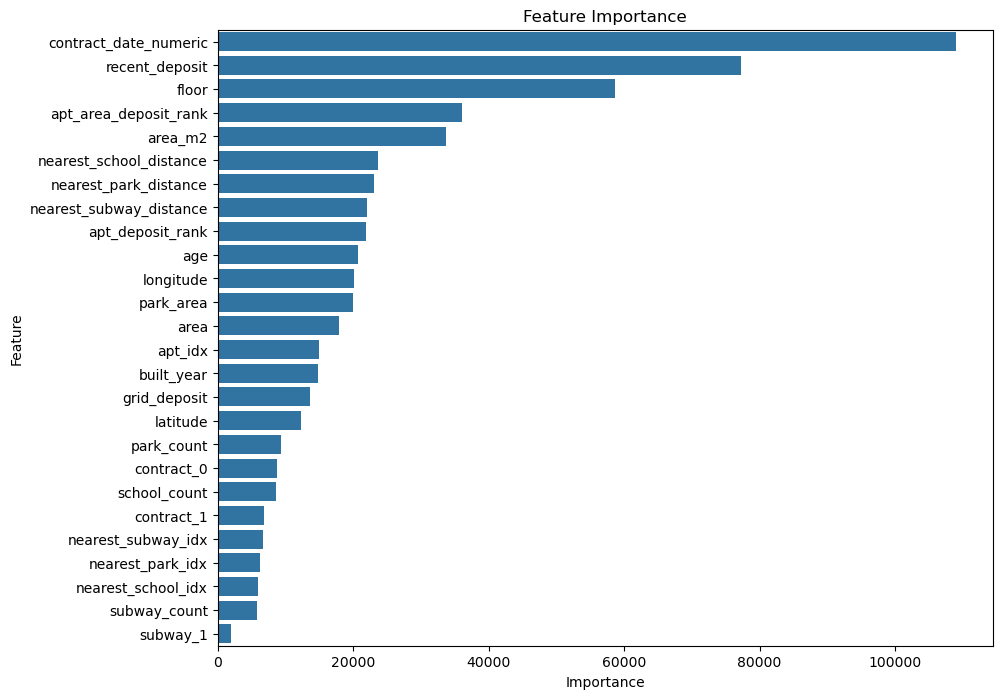

In [18]:
# 전체 검증 세트에 대한 MAE 계산
oof_mae = mean_absolute_error(y, oof_predictions)
print(f"\nOverall OOF MAE: {oof_mae:.4f}")

# 테스트 세트에 대한 최종 예측 결과
y_pred = test_predictions

# LightGBM 모델의 피처 중요도 추출
feature_importance = model.feature_importance()

# 피처 중요도를 DataFrame으로 변환
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importance
})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

In [19]:
y_pred

array([22774.79944191,  7337.27928461,  5675.77923056, ...,
       44445.79748678, 37677.63773692, 38452.58491679])

In [20]:
# Create a DataFrame from y_pred with the same index as X_test
y_pred_df = pd.DataFrame(y_pred, index=range(len(y_pred)), columns=['deposit'])

# Display the DataFrame
y_pred_df.index.name = 'index'
y_pred_df

,deposit
index,
0,22774.799442
1,7337.279285
2,5675.779231
3,5990.245965
4,6190.661164
...,...
150167,38273.865700
150168,43656.365919
150169,44445.797487


In [21]:
y_pred_df['deposit'].mean()

np.float64(39197.253521790284)

In [22]:
y_pred_df.to_csv(os.path.join(submission_path, "Optuna_V9+sub1_lightGBM_Kfold5_12000훈련.csv"), index=True)